<a href="https://colab.research.google.com/github/narayan-bhattarai/AI-Classification/blob/main/GastroVision_MobileNetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install Libraries

In [37]:
!pip install torch torchvision scikit-learn grad-cam


Imports

In [39]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

from sklearn.metrics import classification_report, confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


Extract ZIP

In [40]:
zip_path = "/content/drive/MyDrive/GastroVision.zip"     # YOUR ZIP
extract_path = "/content/GastroVision"

import zipfile
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


Find Dataset Folder

In [43]:
RAW_DATA_DIR = "/content/GastroVision/GastroVision"
print(os.listdir(RAW_DATA_DIR))


['Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel', 'Colon polyps']


In [44]:
import os
import shutil
from sklearn.model_selection import train_test_split

RAW_DATA_DIR = "/content/GastroVision/GastroVision"
BASE_DIR = "/content/GastroVisionSplit"

TRAIN_DIR = BASE_DIR + "/train"
VAL_DIR   = BASE_DIR + "/val"
TEST_DIR  = BASE_DIR + "/test"

# Create folders
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)

# For each class folder
for cls in os.listdir(RAW_DATA_DIR):
    src = os.path.join(RAW_DATA_DIR, cls)
    if not os.path.isdir(src): continue

    images = os.listdir(src)

    train_imgs, temp = train_test_split(images, test_size=0.30, random_state=42)
    val_imgs, test_imgs = train_test_split(temp, test_size=0.33, random_state=42)

    # create class subfolders
    os.makedirs(os.path.join(TRAIN_DIR, cls), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, cls), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, cls), exist_ok=True)

    # move files
    for img in train_imgs:
        shutil.copy(os.path.join(src, img), os.path.join(TRAIN_DIR, cls))

    for img in val_imgs:
        shutil.copy(os.path.join(src, img), os.path.join(VAL_DIR, cls))

    for img in test_imgs:
        shutil.copy(os.path.join(src, img), os.path.join(TEST_DIR, cls))

print("Dataset splitting completed!")


Dataset splitting completed!


In [48]:
DATA_DIR = "/content/GastroVisionSplit"

TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR   = DATA_DIR + "/val"
TEST_DIR  = DATA_DIR + "/test"

print(os.listdir(TEST_DIR))


['Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel', 'Colon polyps']


Datasets & Class Weights

In [46]:
# Labeled train/val sets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_tfms)
val_dataset   = datasets.ImageFolder(root=VAL_DIR,   transform=val_tfms)

class_names = train_dataset.classes
print("Classes:", class_names)
print("Class to idx:", train_dataset.class_to_idx)

# Inverse mapping for predictions
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Compute class counts from train targets
targets = [label for _, label in train_dataset.samples]
class_counts = Counter(targets)
print("Class counts:", class_counts)

# Class weights: inverse frequency
num_classes = len(class_names)
class_weights = torch.tensor(
    [1.0 / class_counts[i] for i in range(num_classes)],
    dtype=torch.float
).to(device)

print("Class weights:", class_weights)


Classes: ['Colon polyps', 'Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel']
Class to idx: {'Colon polyps': 0, 'Erythema': 1, 'Normal esophagus': 2, 'Normal mucosa and vascular pattern in the large bowel': 3}
Class counts: Counter({3: 1026, 0: 574, 2: 98, 1: 10})
Class weights: tensor([0.0017, 0.1000, 0.0102, 0.0010], device='cuda:0')


WeightedRandomSampler & DataLoaders

In [49]:
# Assign a weight to each sample
sample_weights = [class_weights[label].item() for label in targets]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))


Train batches: 54
Val batches  : 16


Model Definition (MobileNetV3-Large)

In [50]:
weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1
base_model = mobilenet_v3_large(weights=weights)

# Replace classifier head
in_features = base_model.classifier[3].in_features
base_model.classifier[3] = nn.Linear(in_features, num_classes)

model = base_model.to(device)
print(model.classifier)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 239MB/s]

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=4, bias=True)
)


Loss, Optimizer, Scheduler

In [53]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)



Training & Validation Epoch Functions

In [54]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total
    return epoch_loss, epoch_acc


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Val", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    return epoch_loss, epoch_acc, all_labels, all_preds


Metrics: Classification Report + Confusion Matrix

In [55]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


def evaluate_metrics(all_labels, all_preds, class_names):
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    print(f"Macro F1-score: {macro_f1:.4f}")
    print("Per-class F1:", dict(zip(class_names, per_class_f1)))

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names)

    return macro_f1


Training Loop (Save Best Model by Macro F1)


========== Epoch 1/20 ==========


Train Loss: 0.2601 | Train Acc: 0.4409


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 1.9024 | Val Acc: 0.0673
Macro F1-score: 0.2152
Per-class F1: {'Colon polyps': np.float64(0.023809523809523808), 'Erythema': np.float64(0.013363028953229399), 'Normal esophagus': np.float64(0.8235294117647058), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.0)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.50      0.01      0.02       164
                                             Erythema       0.01      1.00      0.01         3
                                     Normal esophagus       0.70      1.00      0.82        28
Normal mucosa and vascular pattern in the large bowel       0.00      0.00      0.00       295

                                             accuracy                           0.07       490
                                            macro avg       0.30      0.50      0.22       490
             

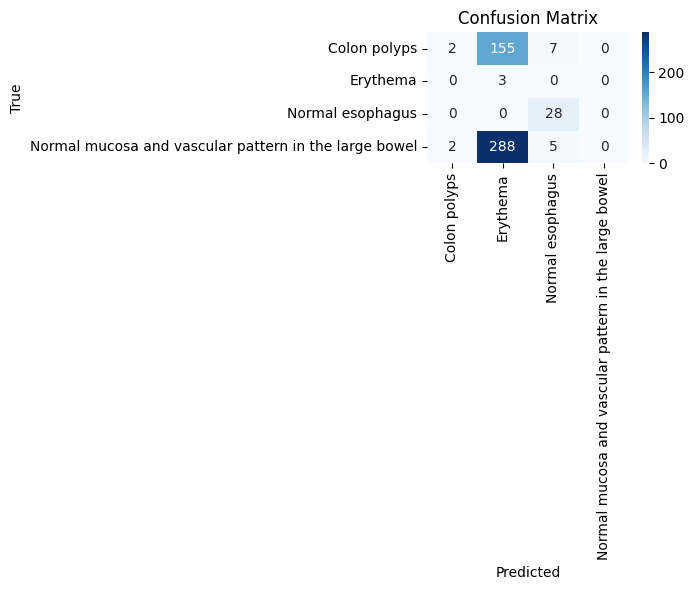

Macro F1: 0.2152
New BEST model saved with Macro F1 = 0.2152

========== Epoch 2/20 ==========


Train Loss: 0.0440 | Train Acc: 0.6464


Val Loss: 1.1200 | Val Acc: 0.4224
Macro F1-score: 0.4486
Per-class F1: {'Colon polyps': np.float64(0.5574468085106383), 'Erythema': np.float64(0.05660377358490566), 'Normal esophagus': np.float64(0.9180327868852459), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.26239067055393583)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.43      0.80      0.56       164
                                             Erythema       0.03      1.00      0.06         3
                                     Normal esophagus       0.85      1.00      0.92        28
Normal mucosa and vascular pattern in the large bowel       0.94      0.15      0.26       295

                                             accuracy                           0.42       490
                                            macro avg       0.56      0.74      0.45       490


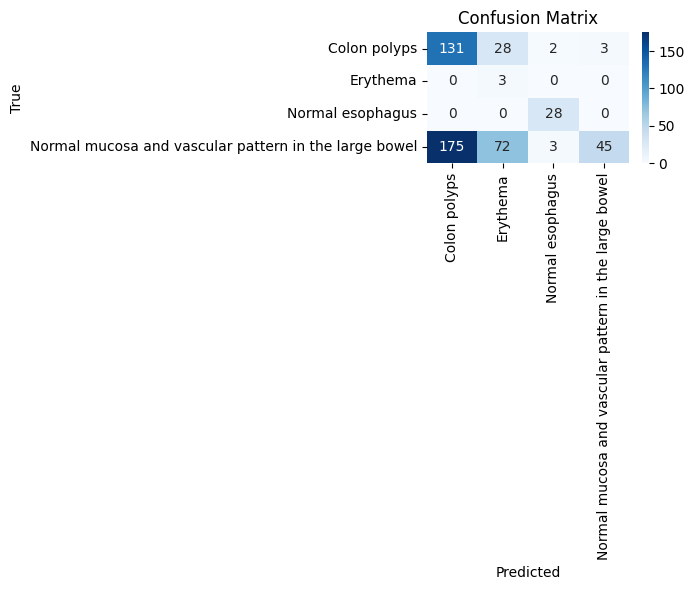

Macro F1: 0.4486
New BEST model saved with Macro F1 = 0.4486

========== Epoch 3/20 ==========


Train Loss: 0.0262 | Train Acc: 0.7681


Val Loss: 0.7928 | Val Acc: 0.6102
Macro F1-score: 0.6115
Per-class F1: {'Colon polyps': np.float64(0.6328600405679513), 'Erythema': np.float64(0.3), 'Normal esophagus': np.float64(0.9655172413793104), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.5476772616136919)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.47      0.95      0.63       164
                                             Erythema       0.18      1.00      0.30         3
                                     Normal esophagus       0.93      1.00      0.97        28
Normal mucosa and vascular pattern in the large bowel       0.98      0.38      0.55       295

                                             accuracy                           0.61       490
                                            macro avg       0.64      0.83      0.61       490
                 

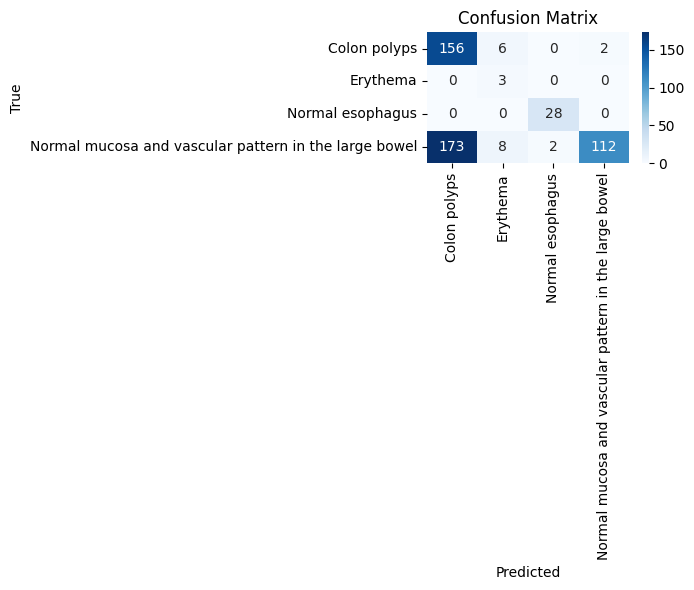

Macro F1: 0.6115
New BEST model saved with Macro F1 = 0.6115

========== Epoch 4/20 ==========


Train Loss: 0.0196 | Train Acc: 0.8413


Val Loss: 0.6110 | Val Acc: 0.7041
Macro F1-score: 0.6795
Per-class F1: {'Colon polyps': np.float64(0.6891891891891891), 'Erythema': np.float64(0.4), 'Normal esophagus': np.float64(0.9333333333333333), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.6952789699570815)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.55      0.93      0.69       164
                                             Erythema       0.29      0.67      0.40         3
                                     Normal esophagus       0.88      1.00      0.93        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.55      0.70       295

                                             accuracy                           0.70       490
                                            macro avg       0.66      0.79      0.68       490
                 

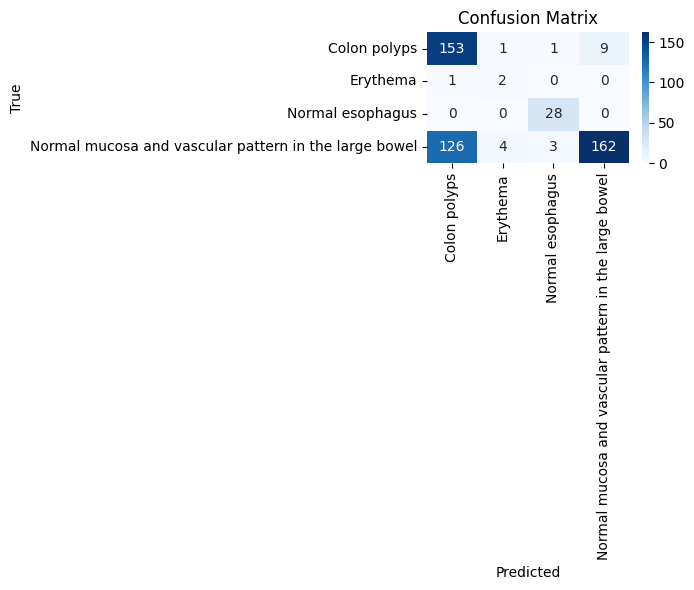

Macro F1: 0.6795
New BEST model saved with Macro F1 = 0.6795

========== Epoch 5/20 ==========


Train Loss: 0.0166 | Train Acc: 0.8776


Val Loss: 0.6731 | Val Acc: 0.6796
Macro F1-score: 0.6107
Per-class F1: {'Colon polyps': np.float64(0.7066974595842956), 'Erythema': np.float64(0.10526315789473684), 'Normal esophagus': np.float64(0.9655172413793104), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.6651884700665188)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.57      0.93      0.71       164
                                             Erythema       0.06      0.67      0.11         3
                                     Normal esophagus       0.93      1.00      0.97        28
Normal mucosa and vascular pattern in the large bowel       0.96      0.51      0.67       295

                                             accuracy                           0.68       490
                                            macro avg       0.63      0.78      0.61       490
 

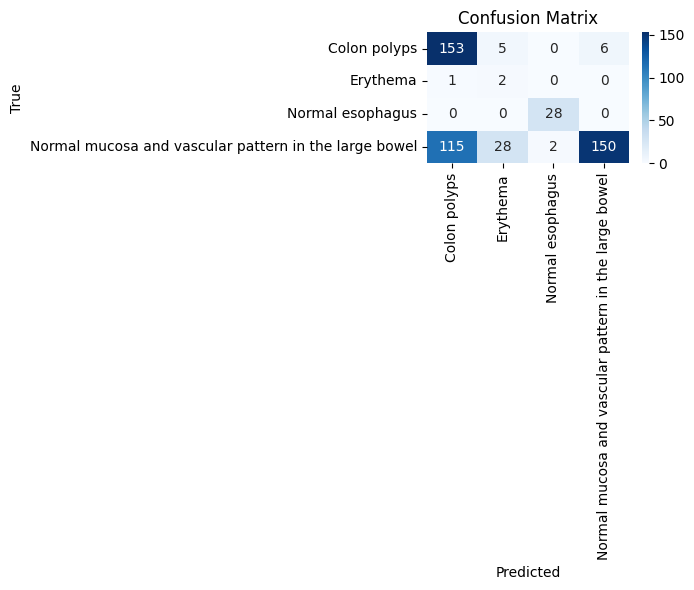

Macro F1: 0.6107

========== Epoch 6/20 ==========


Train Loss: 0.0156 | Train Acc: 0.8759


Val Loss: 0.5340 | Val Acc: 0.7449
Macro F1-score: 0.7539
Per-class F1: {'Colon polyps': np.float64(0.7188940092165899), 'Erythema': np.float64(0.5714285714285714), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.7427385892116183)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.58      0.95      0.72       164
                                             Erythema       0.50      0.67      0.57         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.96      0.61      0.74       295

                                             accuracy                           0.74       490
                                            macro avg       0.75      0.81      0.75       490
  

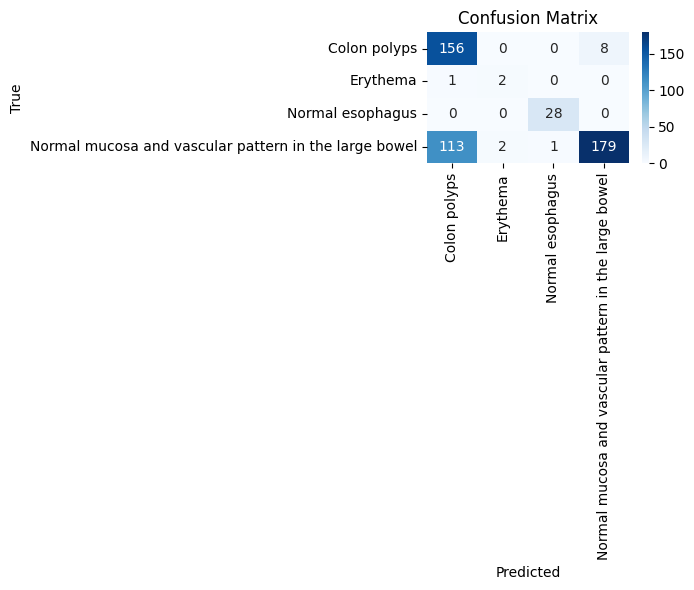

Macro F1: 0.7539
New BEST model saved with Macro F1 = 0.7539

========== Epoch 7/20 ==========


Train Loss: 0.0125 | Train Acc: 0.9075


Val Loss: 0.4670 | Val Acc: 0.7980
Macro F1-score: 0.8042
Per-class F1: {'Colon polyps': np.float64(0.7568922305764411), 'Erythema': np.float64(0.6666666666666666), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.8108108108108109)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.64      0.92      0.76       164
                                             Erythema       0.67      0.67      0.67         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.94      0.71      0.81       295

                                             accuracy                           0.80       490
                                            macro avg       0.80      0.82      0.80       490
  

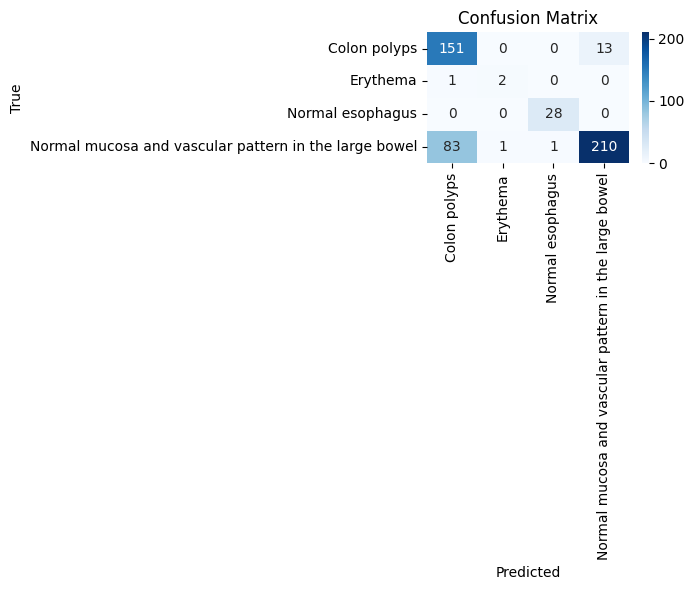

Macro F1: 0.8042
New BEST model saved with Macro F1 = 0.8042

========== Epoch 8/20 ==========


Train Loss: 0.0098 | Train Acc: 0.9251


Val Loss: 0.4518 | Val Acc: 0.8143
Macro F1-score: 0.8126
Per-class F1: {'Colon polyps': np.float64(0.7723785166240409), 'Erythema': np.float64(0.6666666666666666), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.8288973384030418)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.67      0.92      0.77       164
                                             Erythema       0.67      0.67      0.67         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.94      0.74      0.83       295

                                             accuracy                           0.81       490
                                            macro avg       0.81      0.83      0.81       490
  

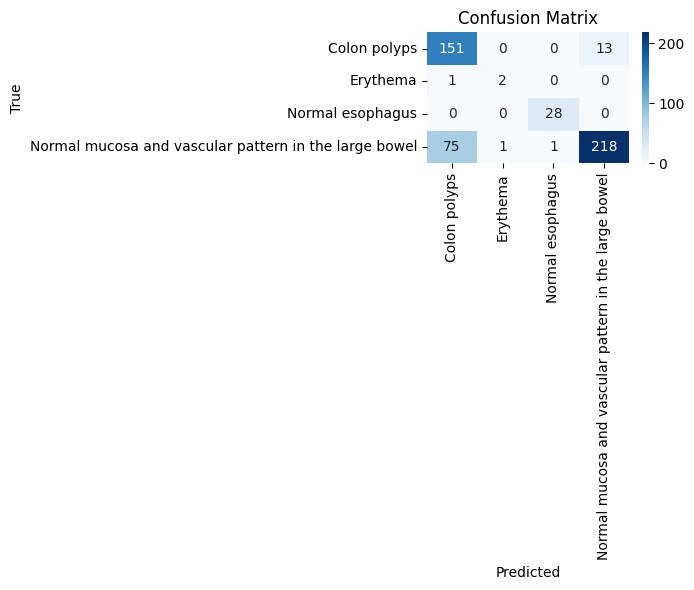

Macro F1: 0.8126
New BEST model saved with Macro F1 = 0.8126

========== Epoch 9/20 ==========


Train Loss: 0.0071 | Train Acc: 0.9432


Val Loss: 0.5028 | Val Acc: 0.8041
Macro F1-score: 0.8407
Per-class F1: {'Colon polyps': np.float64(0.7654320987654321), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.8148148148148148)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.64      0.95      0.77       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.96      0.71      0.81       295

                                             accuracy                           0.80       490
                                            macro avg       0.89      0.83      0.84       490
                 

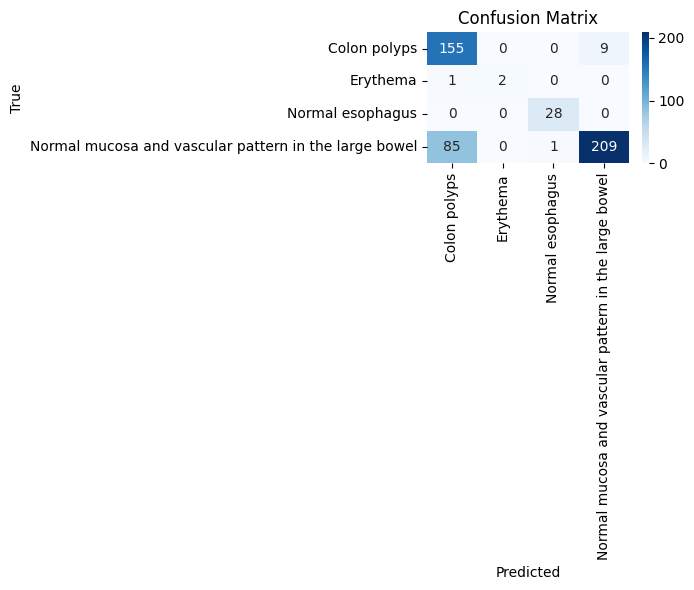

Macro F1: 0.8407
New BEST model saved with Macro F1 = 0.8407

========== Epoch 10/20 ==========


Train Loss: 0.0078 | Train Acc: 0.9379


Val Loss: 0.4278 | Val Acc: 0.8122
Macro F1-score: 0.8117
Per-class F1: {'Colon polyps': np.float64(0.7715736040609137), 'Erythema': np.float64(0.6666666666666666), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.8260038240917782)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.66      0.93      0.77       164
                                             Erythema       0.67      0.67      0.67         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.73      0.83       295

                                             accuracy                           0.81       490
                                            macro avg       0.81      0.83      0.81       490
  

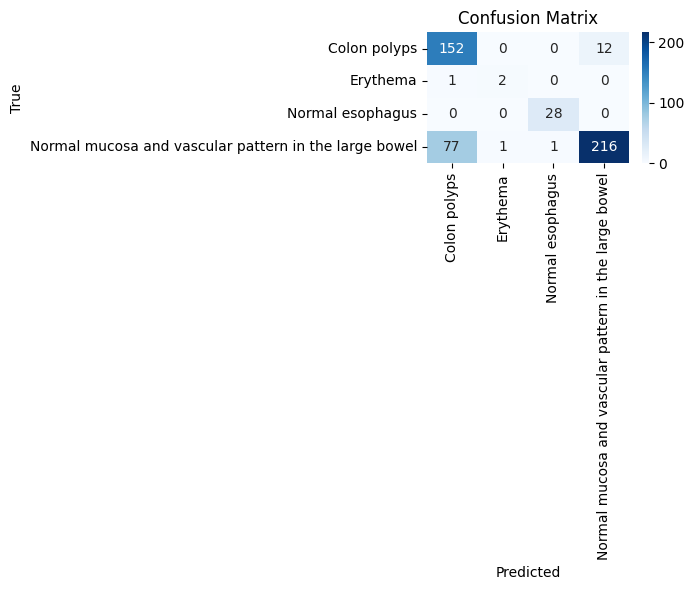

Macro F1: 0.8117

========== Epoch 11/20 ==========


Train Loss: 0.0084 | Train Acc: 0.9297


Val Loss: 0.3996 | Val Acc: 0.8449
Macro F1-score: 0.8615
Per-class F1: {'Colon polyps': np.float64(0.8031496062992126), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.8603351955307262)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.71      0.93      0.80       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.78      0.86       295

                                             accuracy                           0.84       490
                                            macro avg       0.91      0.85      0.86       490
                 

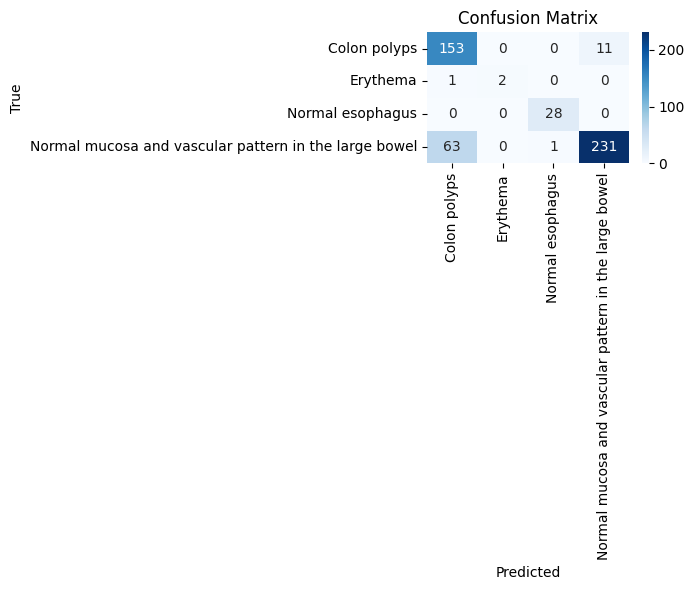

Macro F1: 0.8615
New BEST model saved with Macro F1 = 0.8615

========== Epoch 12/20 ==========


Train Loss: 0.0066 | Train Acc: 0.9578


Val Loss: 0.3685 | Val Acc: 0.8673
Macro F1-score: 0.8729
Per-class F1: {'Colon polyps': np.float64(0.825136612021858), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.8840579710144928)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.75      0.92      0.83       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.83      0.88       295

                                             accuracy                           0.87       490
                                            macro avg       0.92      0.85      0.87       490
                  

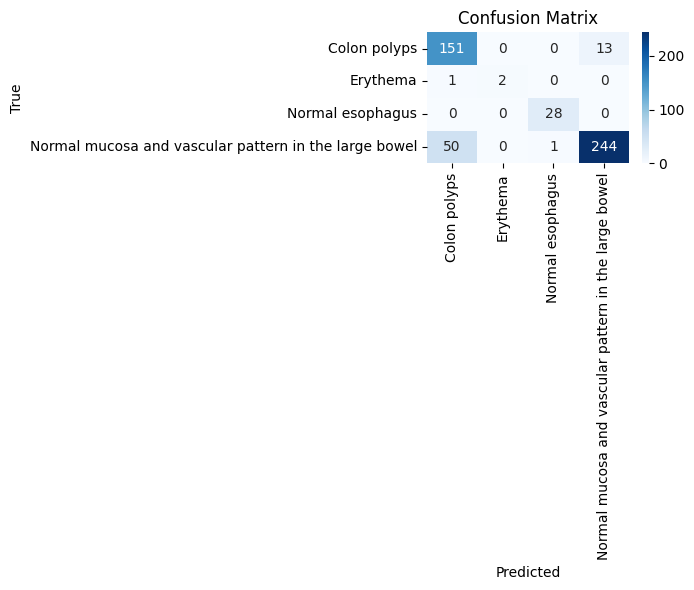

Macro F1: 0.8729
New BEST model saved with Macro F1 = 0.8729

========== Epoch 13/20 ==========


Train Loss: 0.0087 | Train Acc: 0.9461


Val Loss: 0.3309 | Val Acc: 0.9061
Macro F1-score: 0.8853
Per-class F1: {'Colon polyps': np.float64(0.8674698795180723), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9491525423728814), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.9246575342465754)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.86      0.88      0.87       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.90      1.00      0.95        28
Normal mucosa and vascular pattern in the large bowel       0.93      0.92      0.92       295

                                             accuracy                           0.91       490
                                            macro avg       0.92      0.86      0.89       490
                 

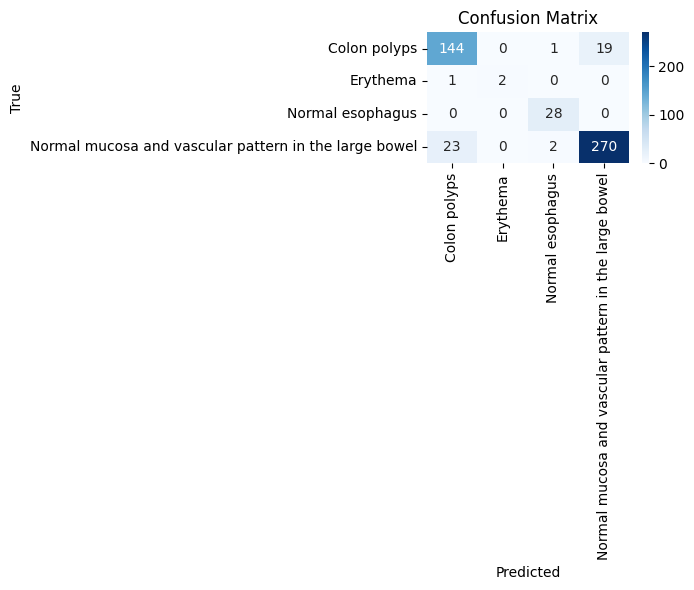

Macro F1: 0.8853
New BEST model saved with Macro F1 = 0.8853

========== Epoch 14/20 ==========


Train Loss: 0.0060 | Train Acc: 0.9543


Val Loss: 0.3318 | Val Acc: 0.8857
Macro F1-score: 0.8826
Per-class F1: {'Colon polyps': np.float64(0.84593837535014), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.9019607843137255)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.78      0.92      0.85       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.86      0.90       295

                                             accuracy                           0.89       490
                                            macro avg       0.92      0.86      0.88       490
                   

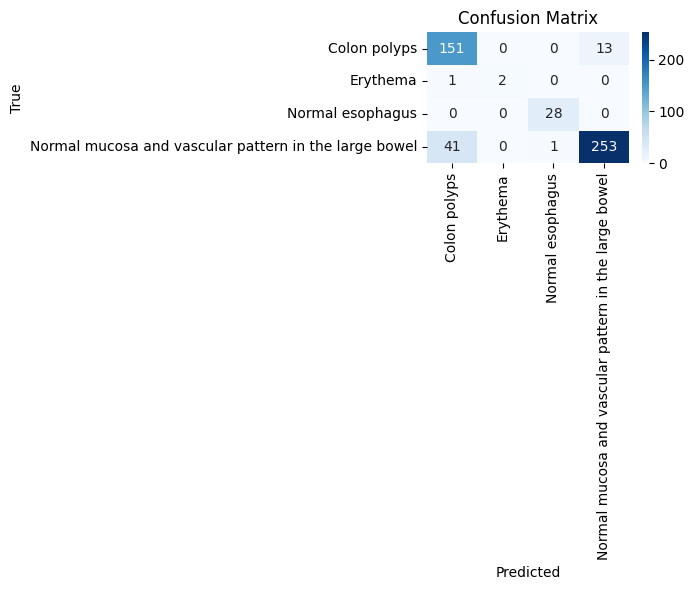

Macro F1: 0.8826

========== Epoch 15/20 ==========


Train Loss: 0.0062 | Train Acc: 0.9602


Val Loss: 0.3325 | Val Acc: 0.8592
Macro F1-score: 0.8686
Per-class F1: {'Colon polyps': np.float64(0.8162162162162162), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.8759124087591241)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.73      0.92      0.82       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.81      0.88       295

                                             accuracy                           0.86       490
                                            macro avg       0.91      0.85      0.87       490
                 

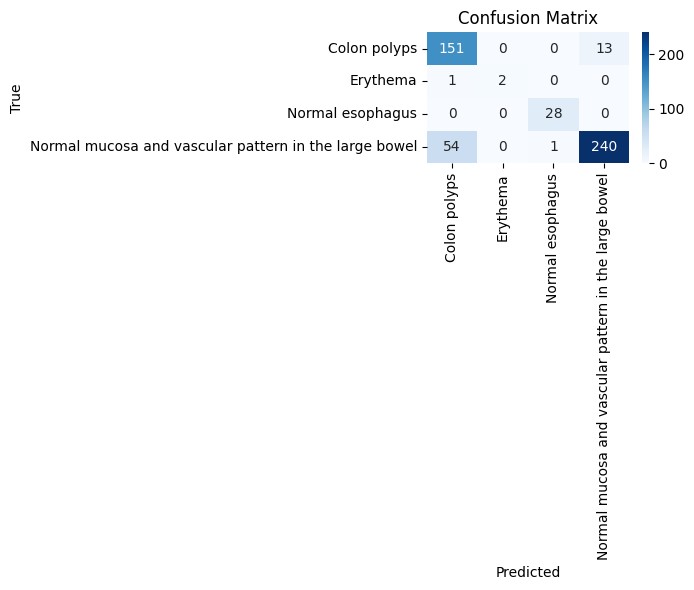

Macro F1: 0.8686

========== Epoch 16/20 ==========


Train Loss: 0.0081 | Train Acc: 0.9479


Val Loss: 0.3372 | Val Acc: 0.8980
Macro F1-score: 0.8814
Per-class F1: {'Colon polyps': np.float64(0.8604651162790697), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9491525423728814), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.916083916083916)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.82      0.90      0.86       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.90      1.00      0.95        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.89      0.92       295

                                             accuracy                           0.90       490
                                            macro avg       0.92      0.86      0.88       490
                  

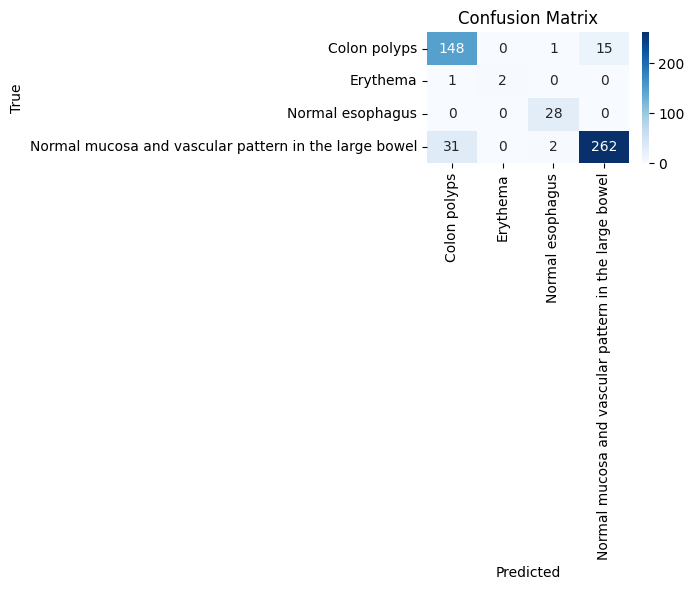

Macro F1: 0.8814

========== Epoch 17/20 ==========


Train Loss: 0.0055 | Train Acc: 0.9596


Val Loss: 0.3004 | Val Acc: 0.9041
Macro F1-score: 0.8847
Per-class F1: {'Colon polyps': np.float64(0.8680351906158358), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9491525423728814), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.9217391304347826)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.84      0.90      0.87       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.90      1.00      0.95        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.90      0.92       295

                                             accuracy                           0.90       490
                                            macro avg       0.92      0.87      0.88       490
                 

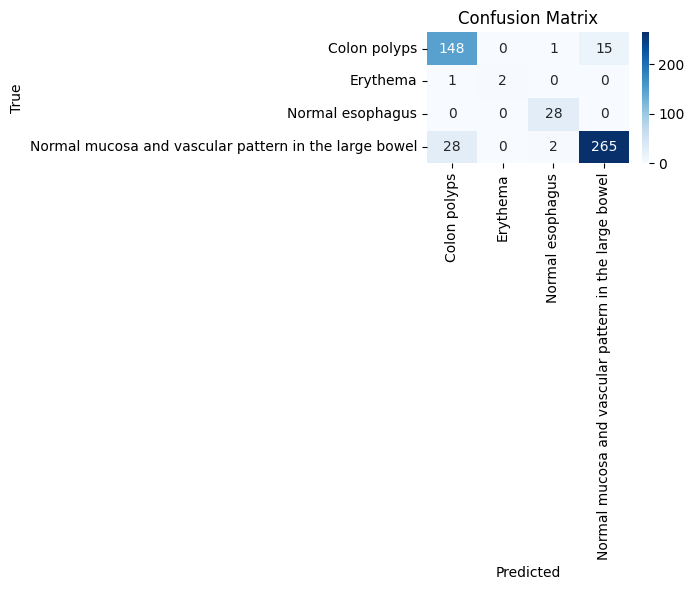

Macro F1: 0.8847
LR Reduced: 0.0001 → 5e-05

========== Epoch 18/20 ==========


Train Loss: 0.0053 | Train Acc: 0.9602


Val Loss: 0.3092 | Val Acc: 0.9041
Macro F1-score: 0.8853
Per-class F1: {'Colon polyps': np.float64(0.8717948717948718), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9491525423728814), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.9203539823008849)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.82      0.93      0.87       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.90      1.00      0.95        28
Normal mucosa and vascular pattern in the large bowel       0.96      0.88      0.92       295

                                             accuracy                           0.90       490
                                            macro avg       0.92      0.87      0.89       490
                 

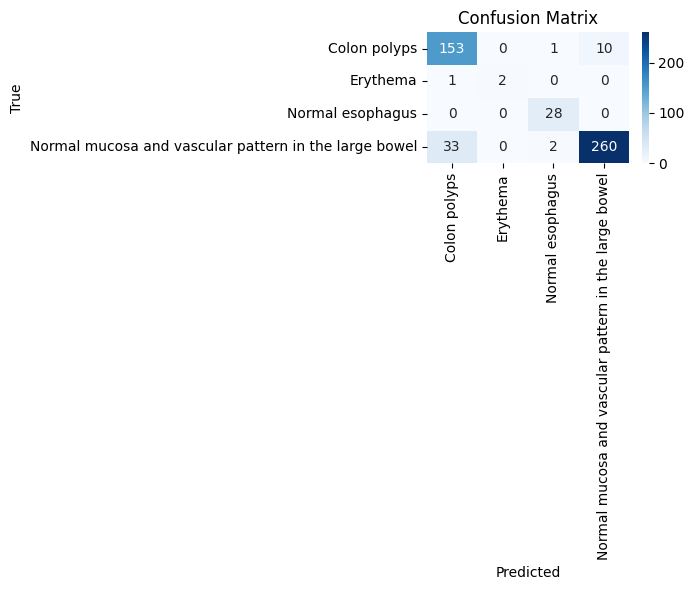

Macro F1: 0.8853
New BEST model saved with Macro F1 = 0.8853

========== Epoch 19/20 ==========


Train Loss: 0.0036 | Train Acc: 0.9742


Val Loss: 0.2750 | Val Acc: 0.9163
Macro F1-score: 0.8988
Per-class F1: {'Colon polyps': np.float64(0.8816568047337278), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.9310344827586207)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.86      0.91      0.88       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.92      0.93       295

                                             accuracy                           0.92       490
                                            macro avg       0.94      0.87      0.90       490
                 

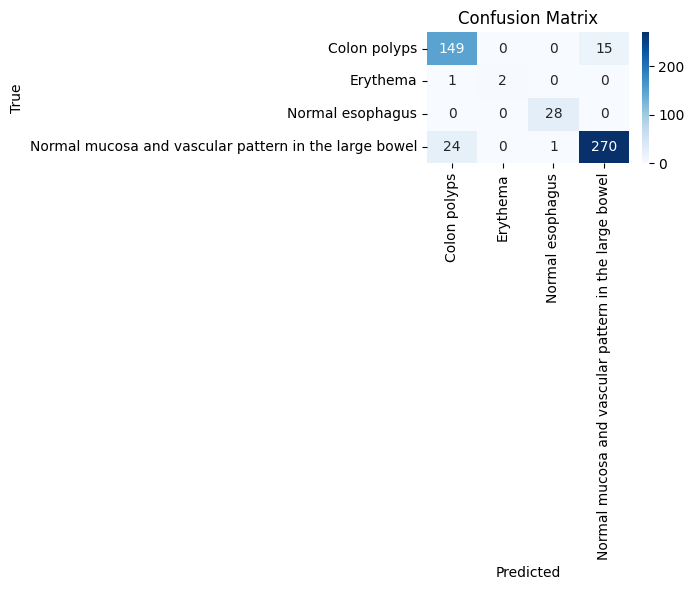

Macro F1: 0.8988
New BEST model saved with Macro F1 = 0.8988

========== Epoch 20/20 ==========


Train Loss: 0.0034 | Train Acc: 0.9772


Val Loss: 0.2904 | Val Acc: 0.9041
Macro F1-score: 0.8924
Per-class F1: {'Colon polyps': np.float64(0.867816091954023), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.9192982456140351)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.82      0.92      0.87       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.89      0.92       295

                                             accuracy                           0.90       490
                                            macro avg       0.93      0.87      0.89       490
                  

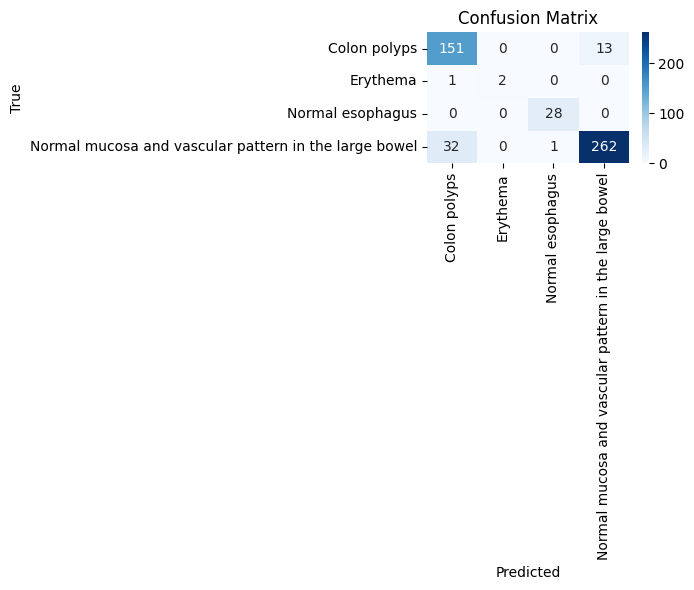

Macro F1: 0.8924


In [58]:
NUM_EPOCHS = 20
best_f1 = 0.0
best_model_path = "/content/model_best_mobilenetv3.pth"

train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_f1s = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n========== Epoch {epoch}/{NUM_EPOCHS} ==========")

    # -------- TRAIN --------
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # -------- VALIDATION --------
    val_loss, val_acc, all_labels, all_preds = validate_one_epoch(
        model, val_loader, criterion, device
    )
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # -------- METRICS --------
    val_macro_f1 = evaluate_metrics(all_labels, all_preds, class_names)
    print(f"Macro F1: {val_macro_f1:.4f}")

    # -------- LOG HISTORY --------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_f1s.append(val_macro_f1)

    # -------- LR SCHEDULER --------
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_macro_f1)
    new_lr = optimizer.param_groups[0]['lr']

    if new_lr != old_lr:
        print(f"LR Reduced: {old_lr} → {new_lr}")

    # -------- SAVE BEST MODEL --------
    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"New BEST model saved with Macro F1 = {best_f1:.4f}")


Plot Training Curves

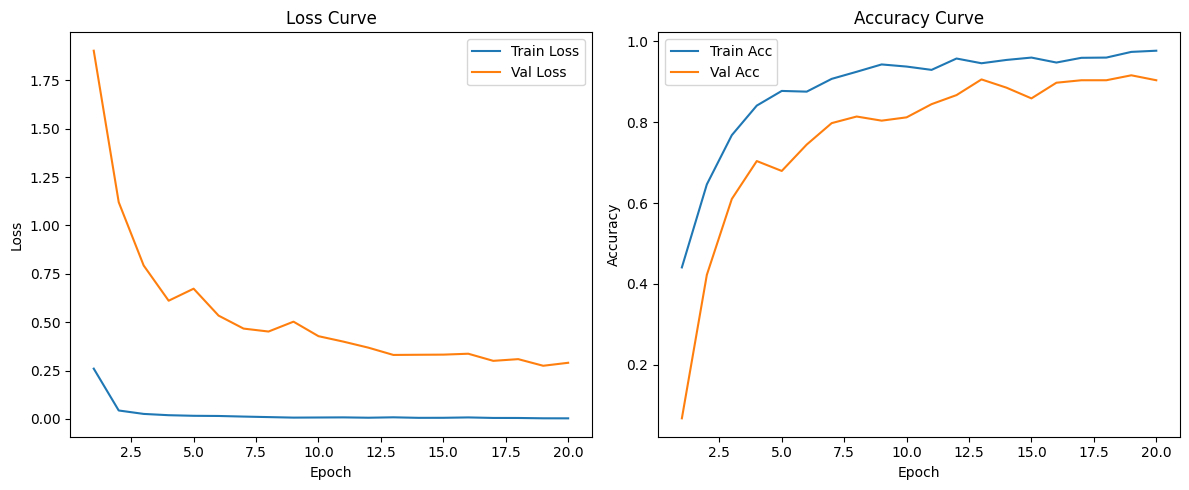

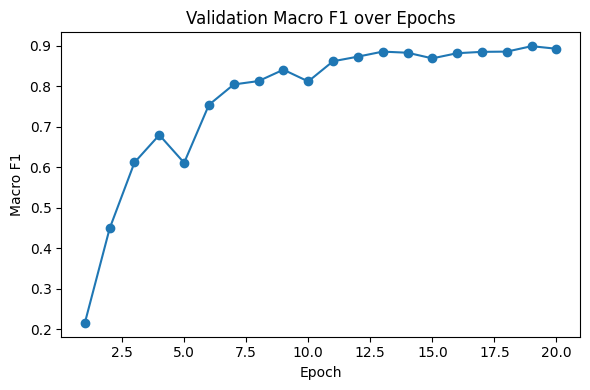

In [59]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, val_f1s, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.title("Validation Macro F1 over Epochs")
plt.tight_layout()
plt.show()


Final Best Model - Val Loss: 0.2750 | Val Acc: 0.9163
Macro F1-score: 0.8988
Per-class F1: {'Colon polyps': np.float64(0.8816568047337278), 'Erythema': np.float64(0.8), 'Normal esophagus': np.float64(0.9824561403508771), 'Normal mucosa and vascular pattern in the large bowel': np.float64(0.9310344827586207)}

Classification Report:

                                                       precision    recall  f1-score   support

                                         Colon polyps       0.86      0.91      0.88       164
                                             Erythema       1.00      0.67      0.80         3
                                     Normal esophagus       0.97      1.00      0.98        28
Normal mucosa and vascular pattern in the large bowel       0.95      0.92      0.93       295

                                             accuracy                           0.92       490
                                            macro avg       0.94      0.87      0.90       49

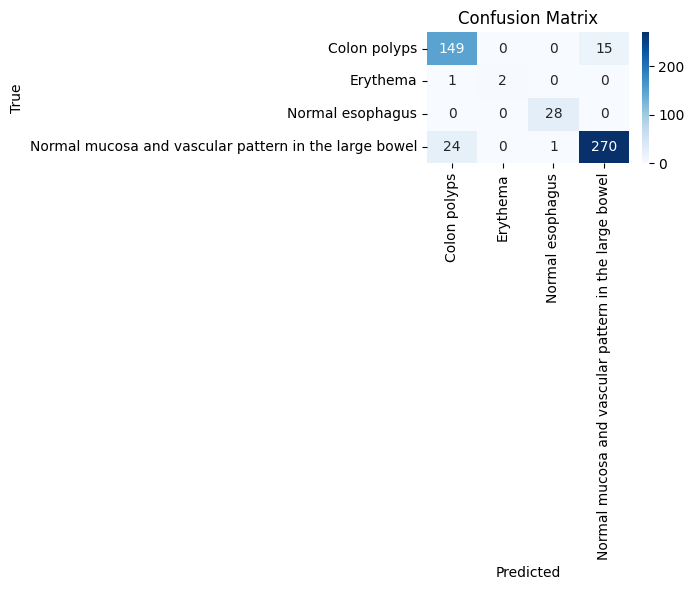

Final Macro F1 (Best Model): 0.8988


In [60]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

val_loss, val_acc, all_labels, all_preds = validate_one_epoch(
    model, val_loader, criterion, device
)

print(f"Final Best Model - Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
final_macro_f1 = evaluate_metrics(all_labels, all_preds, class_names)
print(f"Final Macro F1 (Best Model): {final_macro_f1:.4f}")


In [66]:
class GastroVisionTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.paths = []

        # loop through class folders
        for cls in os.listdir(img_dir):
            cls_path = os.path.join(img_dir, cls)
            if not os.path.isdir(cls_path):
                continue

            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)

                # ignore any directories
                if os.path.isdir(img_path):
                    continue

                # allow only image files
                if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.paths.append(img_path)

        self.paths = sorted(self.paths)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img_name = os.path.basename(img_path)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_name


In [68]:
test_dataset = GastroVisionTestDataset(TEST_DIR, transform=test_tfms)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,    # FIX
    pin_memory=True
)


In [69]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

rows = []

with torch.no_grad():
    for images, img_names in tqdm(test_loader, desc="Test Inference"):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        for img_name, pred_idx in zip(img_names, preds):
            label_str = idx_to_class[pred_idx]  # e.g., 'colon_polyp'
            rows.append([img_name, label_str])

pred_df = pd.DataFrame(rows, columns=["image_id", "label"])
pred_df.head()


Test Inference: 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]


,image_id,label
0,02ae2444-eddf-4fec-8b87-babc265d1553.jpg,Colon polyps
1,050f7775-4c27-4896-a9bd-c250d2c284a5.jpg,Colon polyps
2,0ac8f349-3704-4ed4-a596-5a30736e1f0c.jpg,Colon polyps
3,0b54479a-f17b-4802-a334-1d016d819441.jpg,Colon polyps
4,0b7e3eeb-0461-4c4d-bbe4-be8838d70be5.jpg,Colon polyps


In [70]:
output_csv_path = "/content/predictions.csv"
pred_df.to_csv(output_csv_path, index=False)
print("Saved predictions to:", output_csv_path)


Saved predictions to: /content/predictions.csv


In [71]:
!pip install grad-cam


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 25

In [72]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [73]:
target_layers = [model.features[-1]]


In [77]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Pick last feature layer of MobileNetV3
target_layers = [model.features[-1]]

def generate_gradcam(model, img_tensor, original_img, class_idx):
    model.eval()

    cam = GradCAM(model=model, target_layers=target_layers)

    targets = [ClassifierOutputTarget(class_idx)]

    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0]

    # original_img should be HxWx3, uint8 or float32
    rgb_img = np.float32(original_img) / 255.0

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    return cam_image, grayscale_cam


In [78]:
def show_gradcam(img, cam_img, title="Grad-CAM"):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cam_img)
    plt.title(title)
    plt.axis("off")

    plt.show()


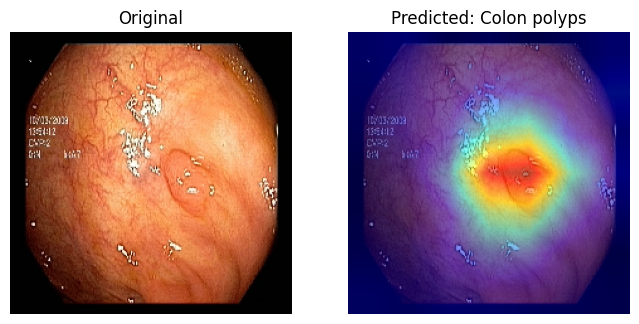

In [82]:
idx = 10  # choose any validation index

img_path, label = val_dataset.samples[idx]

# Load original image (RGB)
orig_img = cv2.imread(img_path)[:, :, ::-1]
orig_img = cv2.resize(orig_img, (224, 224))

# Preprocess for model
input_tensor = val_tfms(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)

# Forward pass
output = model(input_tensor)
pred_idx = output.argmax(1).item()

# Generate Grad-CAM
cam_img, _ = generate_gradcam(model, input_tensor, orig_img, pred_idx)

pred_class = idx_to_class[pred_idx]

show_gradcam(orig_img, cam_img, title=f"Predicted: {pred_class}")


In [83]:
misclassified = []

model.eval()
with torch.no_grad():
    for i, (img, label) in enumerate(val_dataset):
        img_path, true_label = val_dataset.samples[i]
        orig = cv2.imread(img_path)[:, :, ::-1]

        inp = val_tfms(Image.open(img_path)).unsqueeze(0).to(device)
        pred = model(inp).argmax(1).item()

        if pred != true_label:
            misclassified.append((img_path, true_label, pred))

len(misclassified)


41

True: Colon polyps
Pred: Normal mucosa and vascular pattern in the large bowel


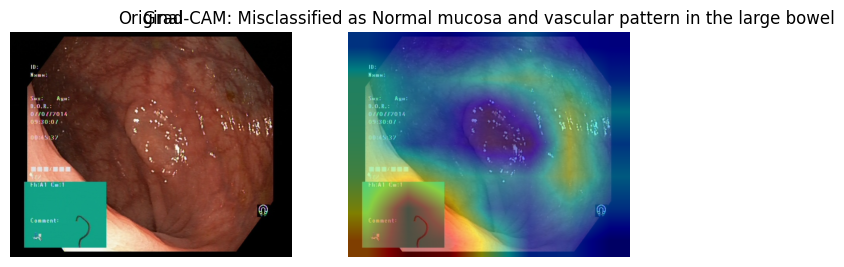

In [85]:
# Pick first misclassified example
img_path, true_label, pred_label = misclassified[0]

# Load original image in RGB
orig_img = cv2.imread(img_path)[:, :, ::-1]

# Prepare model input (224x224)
input_tensor = val_tfms(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)

# Generate CAM (224x224)
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(pred_label)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

cam_resized = cv2.resize(grayscale_cam, (orig_img.shape[1], orig_img.shape[0]))

# Prepare original image 0–1
rgb_img = np.float32(orig_img) / 255.0

# Overlay CAM on original image
cam_image = show_cam_on_image(rgb_img, cam_resized, use_rgb=True)

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])

# Display
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig_img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cam_image)
plt.title(f"Grad-CAM: Misclassified as {class_names[pred_label]}")
plt.axis("off")

plt.show()
